In [1]:
import torchvision.transforms as transforms
from torchvision import transforms
from torchvision.io import read_image
import torch
from PIL import Image
import torchvision.models as models
import numpy as np

from modeci_mdf.interfaces.pytorch import pytorch_to_mdf
from modeci_mdf.execution_engine import EvaluableGraph

In [20]:
input_image = Image.open("img1.jpeg")
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)

tensor([ 1.7417e+01,  2.2863e+01,  1.3797e+00,  7.1249e+00,  6.3360e+00,
         8.1005e+00,  5.4482e+00,  6.5636e+00,  6.5231e+00, -3.7623e+00,
         2.9051e+00,  4.8801e+00,  3.9653e+00,  7.5227e-01,  1.3016e+00,
         2.7390e+00,  2.2261e+00,  1.6881e+00, -4.3078e-01, -6.5009e-01,
         2.1896e+00,  8.8289e+00,  5.8561e+00,  6.2882e+00,  2.3906e+00,
         4.1872e+00,  7.5053e+00,  7.3094e+00,  3.4515e+00,  1.2716e+01,
         6.6230e+00,  5.9535e+00,  6.6287e+00,  6.5010e+00,  2.9714e+00,
         7.3092e+00,  7.0671e+00,  4.6031e+00,  8.5562e+00,  2.2519e+00,
         7.6620e+00,  3.1402e+00,  5.8173e+00,  5.6542e+00,  3.1143e+00,
         4.7378e-01,  6.3030e+00,  5.3189e+00,  2.4562e+00,  3.3857e+00,
         2.5189e+00,  3.1166e+00, -1.8593e-01, -1.6071e+00, -3.1567e-01,
         1.4424e+00, -1.4160e+00, -2.6358e+00,  7.3904e-01,  2.4608e-01,
         2.4219e+00,  8.2855e-01,  1.6473e+00,  1.4045e+00,  1.5039e+00,
         1.6858e+00,  1.8922e+00,  2.1088e+00,  7.5

In [21]:
mdf_model, params_dict = pytorch_to_mdf(
        model=model,
        args=input_batch,
        trace=True,
    )

In [23]:
mdf_graph = mdf_model.graphs[0]
# mdf_graph_nodes = mdf_graph.nodes[id='Conv_499']
params_dict["input1"] = input_batch.detach().numpy()

eg = EvaluableGraph(graph=mdf_graph, verbose=False)

eg.evaluate(initializer=params_dict)

output_mdf = eg.output_enodes[0].get_output()
op_label_mdf = np.argmax(output_mdf)


Init graph: ResNetGraph
Evaluating graph: ResNetGraph, root nodes: ['Conv_192'], with array format numpy


Converting MDF graph: ResNetGraph to graphviz (level: 1, format: png)
    Node: Conv_192
    Node: Relu_125
    Node: MaxPool_126
    Node: Conv_195
    Node: Relu_129
    Node: Conv_198
    Node: Add_132
    Node: Relu_133
    Node: Conv_201
    Node: Relu_136
    Node: Conv_204
    Node: Add_139
    Node: Relu_140
    Node: Conv_207
    Node: Relu_143
    Node: Conv_210
    Node: Conv_213
    Node: Add_148
    Node: Relu_149
    Node: Conv_216
    Node: Relu_152
    Node: Conv_219
    Node: Add_155
    Node: Relu_156
    Node: Conv_222
    Node: Relu_159
    Node: Conv_225
    Node: Conv_228
    Node: Add_164
    Node: Relu_165
    Node: Conv_231
    Node: Relu_168
    Node: Conv_234
    Node: Add_171
    Node: Relu_172
    Node: Conv_237
    Node: Relu_175
    Node: Conv_240
    Node: Conv_243
    Node: Add_180
    Node: Relu_181
    Node: Conv_246
    Node: Relu_184
    Node: Conv_249
    Node: Add_187
    Node: Relu_188
    Node: GlobalAveragePool_189
    Node: Flatten_190
    Nod

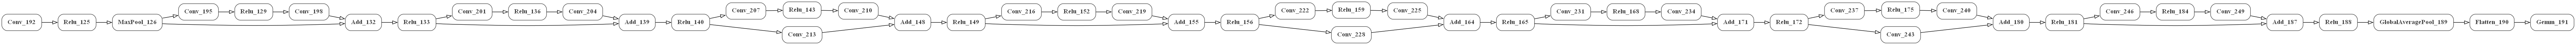

In [24]:
mdf_model.to_graph_image(
    engine="dot",
    output_format="png",
    view_on_render=False,
    level=1,
    filename_root="example",
    only_warn_on_fail=True,
    is_horizontal = True
)
from IPython.display import Image
Image(filename="example.png")

In [26]:
try:
    from IPython.display import Image
    onnx_graph = Image(filename="example.onnx.png")
    display(onnx_graph)
    
except:
    import netron
    torch.onnx.export(
            model,
            input_batch,
            "example.onnx",
            verbose=True,
            input_names=[],
            opset_version=9,
        )
    netron.start("example.onnx")


graph(%input.1 : Float(1, 3, 224, 224, strides=[150528, 50176, 224, 1], requires_grad=0, device=cpu),
      %fc.weight : Float(1000, 512, strides=[512, 1], requires_grad=1, device=cpu),
      %fc.bias : Float(1000, strides=[1], requires_grad=1, device=cpu),
      %193 : Float(64, 3, 7, 7, strides=[147, 49, 7, 1], requires_grad=0, device=cpu),
      %194 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %196 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %197 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %199 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %200 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %202 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %203 : Float(64, strides=[1], requires_grad=0, device=cpu),
      %205 : Float(64, 64, 3, 3, strides=[576, 9, 3, 1], requires_grad=0, device=cpu),
      %206 : Float(64, strides=[1], require